# Importing Libraries

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


# Data Preprocessing

## Function To Transform Images For Dataset

In [5]:
# Define data transformations with augmentation and normalization
transform = transforms.Compose([
    transforms.RandomRotation(10),  # Randomly rotate images by up to 10 degrees
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.Resize((32, 32)),  # Resize images to 32x32
    transforms.ToTensor(),  # Convert image to Tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize with mean and std dev
])

## Loading dataset with transformations

In [6]:
# Load datasets with transformations
train_ds = datasets.FashionMNIST('F_MNIST_data', download=True, train=True, transform=transform)
test_ds = datasets.FashionMNIST('F_MNIST_data', download=True, train=False, transform=transform)



100%|██████████| 26421880/26421880 [00:04<00:00, 5634029.65it/s] 


Extracting F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to F_MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 212646.43it/s]


Extracting F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to F_MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3171656.34it/s]


Extracting F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to F_MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 11364356.31it/s]

Extracting F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to F_MNIST_data/FashionMNIST/raw



## Data Loaders

In [7]:
# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)


# Dataset Attributes

## Number of Classes

In [8]:
def show_classes(dataset):
    # Get the category names
    categories = dataset.classes
    
    # Print out the categories with their indices
    for idx, category in enumerate(categories):
        print(f'{idx}: {category}')

# Example usage:
show_classes(train_ds)


0: T-shirt/top
1: Trouser
2: Pullover
3: Dress
4: Coat
5: Sandal
6: Shirt
7: Sneaker
8: Bag
9: Ankle boot


## Number of Images in Each class

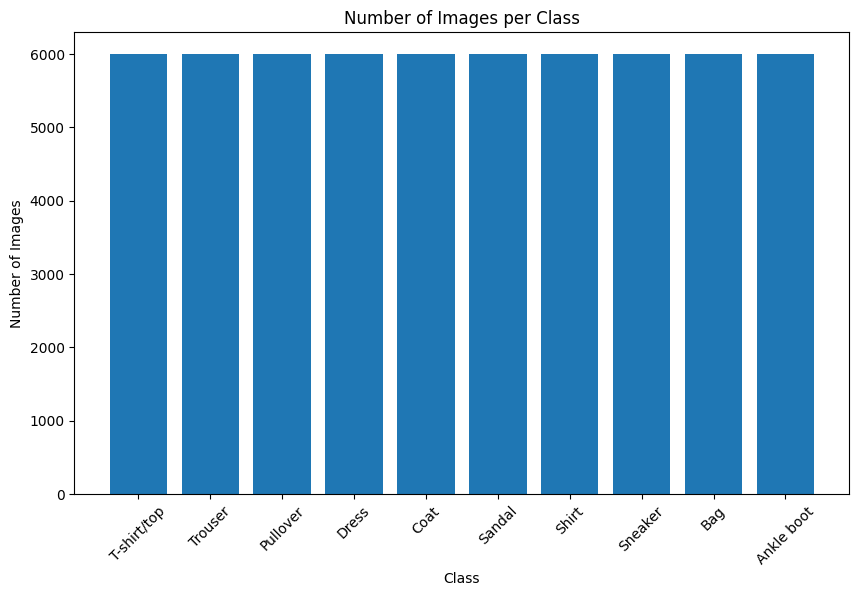

In [9]:
def show_class_distribution(dataset):
    from collections import Counter
    import matplotlib.pyplot as plt

    # Count the number of samples per class
    labels = [label for _, label in dataset]
    counter = Counter(labels)
    class_names = dataset.classes
    counts = [counter[i] for i in range(len(class_names))]

    # Plot the distribution
    plt.figure(figsize=(10, 6))
    plt.bar(class_names, counts)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Number of Images per Class')
    plt.xticks(rotation=45)
    plt.show()

# Example usage
show_class_distribution(train_ds)


## Image Size in dataset

In [10]:
def show_image_size(dataset):
    img, _ = dataset[0]
    print(f'Image Size: {img.shape}')

# Example usage
show_image_size(train_ds)


Image Size: torch.Size([1, 32, 32])


## Displaying different images in traning set

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def show_images(images, labels, classes):
    # Check if the number of images is 1 or more
    if len(images) == 1:
        fig, ax = plt.subplots(figsize=(5, 5))
        img = images[0] / 2 + 0.5  # Unnormalize the image
        ax.imshow(np.transpose(img.numpy(), (1, 2, 0)), cmap='gray')
        ax.set_title(classes[labels[0]])
        ax.axis('off')
    else:
        fig, axes = plt.subplots(1, len(images), figsize=(12, 12))
        for i, (img, label) in enumerate(zip(images, labels)):
            img = img / 2 + 0.5  # Unnormalize the image
            npimg = img.numpy()
            axes[i].imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
            axes[i].set_title(classes[label])
            axes[i].axis('off')
        plt.tight_layout()
    plt.show()



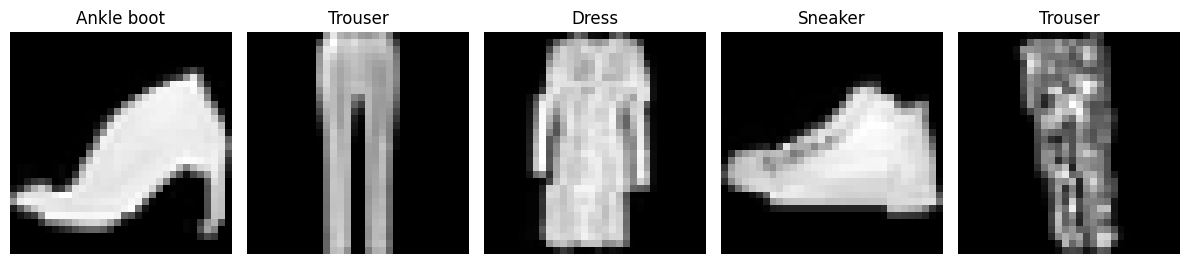

In [25]:
# Example usage: Display random images from the dataset
def display_random_images(dataset, num_images=5):
    indices = np.random.choice(len(dataset), num_images, replace=False)
    images, labels = zip(*[dataset[i] for i in indices])
    show_images(images, labels, dataset.classes)

# Call the function to display random images from the training dataset
display_random_images(train_ds)

# Model Building and Training 

## Defining model

In [16]:
# Define the model
class FashionMNISTModel(nn.Module):
    def __init__(self):
        super(FashionMNISTModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = FashionMNISTModel()

## Training model

### Function to train model

In [17]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    train_loss_history = []
    train_acc_history = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0
        
        for images, labels in train_loader:
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize parameters
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct_preds / total_preds
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
    
    return train_loss_history, train_acc_history



### Loss function and optimizer

In [18]:
# Set up the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


### Training

In [19]:
# Train the model and get history
train_loss_history, train_acc_history = train_model(model, train_loader, criterion, optimizer)

Epoch 1/10, Loss: 0.6381, Accuracy: 0.7673
Epoch 2/10, Loss: 0.4433, Accuracy: 0.8411
Epoch 3/10, Loss: 0.3927, Accuracy: 0.8593
Epoch 4/10, Loss: 0.3595, Accuracy: 0.8710
Epoch 5/10, Loss: 0.3356, Accuracy: 0.8793
Epoch 6/10, Loss: 0.3176, Accuracy: 0.8857
Epoch 7/10, Loss: 0.3049, Accuracy: 0.8910
Epoch 8/10, Loss: 0.2904, Accuracy: 0.8980
Epoch 9/10, Loss: 0.2829, Accuracy: 0.8982
Epoch 10/10, Loss: 0.2772, Accuracy: 0.8992


# Model Evaluation

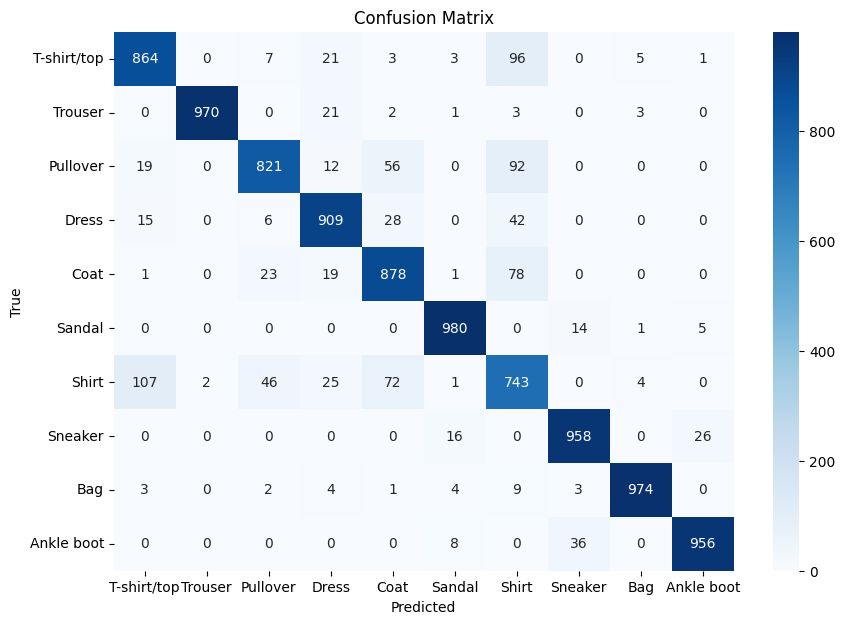

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.86      0.86      0.86      1000
     Trouser       1.00      0.97      0.98      1000
    Pullover       0.91      0.82      0.86      1000
       Dress       0.90      0.91      0.90      1000
        Coat       0.84      0.88      0.86      1000
      Sandal       0.97      0.98      0.97      1000
       Shirt       0.70      0.74      0.72      1000
     Sneaker       0.95      0.96      0.95      1000
         Bag       0.99      0.97      0.98      1000
  Ankle boot       0.97      0.96      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

Weighted F1 Score: 0.91


In [20]:
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Compute classification report
    cr = classification_report(y_true, y_pred, target_names=test_loader.dataset.classes, output_dict=True)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_loader.dataset.classes, yticklabels=test_loader.dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Print classification report
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names=test_loader.dataset.classes))

    # Return F1 score
    return cr['weighted avg']['f1-score']

# Evaluate the model
f1_score = evaluate_model(model, test_loader)
print(f'Weighted F1 Score: {f1_score:.2f}')


# Displaying Training loss and accuracy

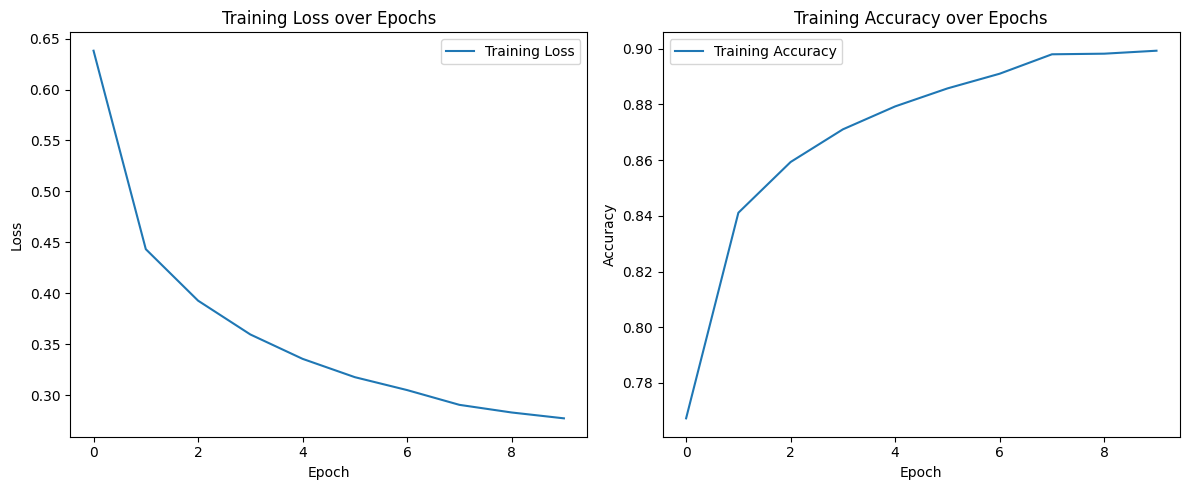

In [21]:
# Plot learning curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


# Making prediction on single Image

Predicted Class: Ankle boot, True Class: Ankle boot


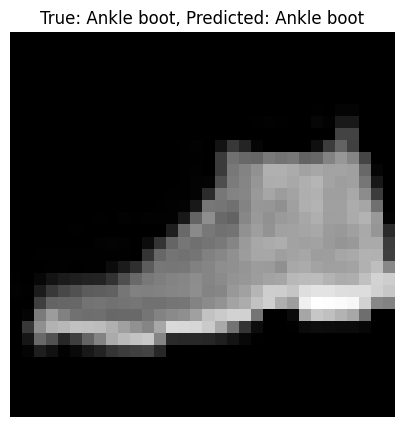

In [30]:
# Define the classes for Fashion MNIST
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def predict_and_show_single_image(model, image, true_label, classes):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for inference
        output = model(image.unsqueeze(0))  # Add batch dimension and pass through model
        _, predicted = torch.max(output.data, 1)  # Get the predicted class index
    
    predicted_class = predicted.item()  # Extract the predicted class

    # Print the prediction and true class
    print(f'Predicted Class: {classes[predicted_class]}, True Class: {classes[true_label]}')

    # Show the image with the predicted and true labels
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(image.squeeze().numpy(), cmap='gray')  # Display the image
    ax.set_title(f'True: {classes[true_label]}, Predicted: {classes[predicted_class]}')
    ax.axis('off')
    plt.show()

# Load a single image from the test set
single_image, label = test_ds[0]
predict_and_show_single_image(model, single_image, label, classes)


In [31]:
import torch

def save_model(model, file_path):
    torch.save(model.state_dict(), file_path)
    print(f"Model saved to {file_path}")
    
save_model(model, "fashion_mnist_model.pth")


Model saved to fashion_mnist_model.pth
